In [251]:
import os
import math
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

import csv
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import feature_selection, linear_model

# Load in the Data

In [252]:
df = pd.read_csv('C:/Users/Collin/Documents/DAT-ATX-2/final_project/data/Bid_Data.csv')
len(df)

32447

# Formatting & Identifying the Data

In [253]:
df = df[df['Rank'] == 1]
df = df[df['Type'] == 'Construction']

df = df.drop(' From', 1)
df = df.drop('To', 1)
df = df.drop('Contract Description', 1)
df = df.drop('Contractor', 1)
df = df.drop('Contract Category', 1)
df = df.drop('LNG MON', 1)
df = df.drop('MONTH', 1)

df['Award Amount'] = df['Award Amount'].str.lstrip('$')
df['Engineers Estimate'] = df['Engineers Estimate'].str.lstrip('$')
df['Award Amount'] = df['Award Amount'].str.replace(',','').astype(float)
df['Engineers Estimate'] = df['Engineers Estimate'].str.replace(',','').astype(float)

#Renaming Variables
df['EngEst'] = df['Engineers Estimate']
df['NBidders'] = df['Number of Bidders']
df['Date'] = pd.to_datetime(df['Letting Date'])
df.set_index('Date' , inplace=True)
df['Year'] = df.index.year
df['Month'] = df.index.month
df['WinBid'] = df['Award Amount']

# Creating New Varialbes
df['Diff'] = df['EngEst'] - df['WinBid']
df['lnWinBid'] = np.log(df['WinBid'])
df['lnEngEst'] = np.log(df['EngEst'])
df['DiffLn'] = df['lnWinBid'] - df['lnEngEst']
df['Within10Percent'] = 1 
df['PercentOff'] = df['Diff'] / df['EngEst']
df['MoreOrLessThan10'] = 0
df['LessThan10'] = 0
df['MoreThan10'] = 0

df.loc[(df.PercentOff > .10) , 'Within10Percent'] = 0
df.loc[(df.PercentOff < -.10) , 'Within10Percent'] = 0
df.loc[(df.PercentOff > .10) , 'MoreOrLessThan10'] = 1
df.loc[(df.PercentOff < -.10) , 'MoreOrLessThan10'] = 2
df.loc[(df.PercentOff > .10) , 'MoreThan10'] = 1
df.loc[(df.PercentOff < -.10) , 'LessThan10'] = 1

print len(df)

5177


## Exploring the Data

## We see that Bids are Log Normally Distributed

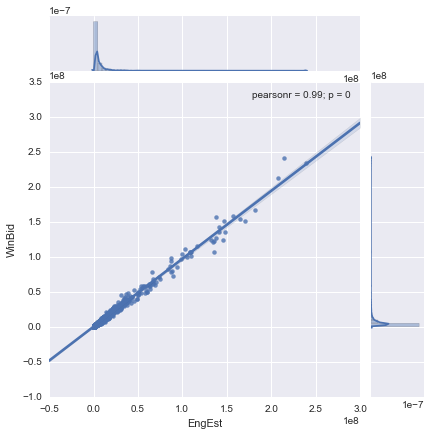

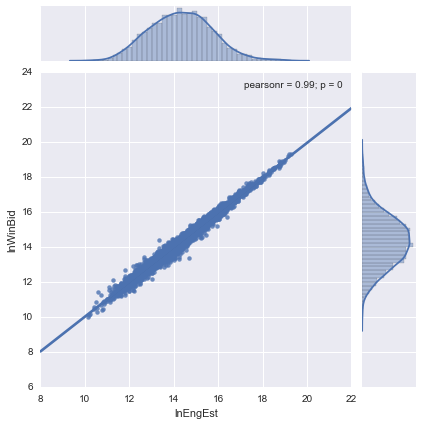

In [254]:
sns.jointplot(x="EngEst", y="WinBid", data=df, kind="reg"); sns.jointplot(x="lnEngEst", y="lnWinBid", data=df, kind="reg");

## Because the TxDot Estimates are so highly correlated with the winning bid, we can use it as a baseline for the model predictions

## My idea was to classify the TxDot Estimates according to their scoring method of estimating within 10% of the winning bid and then having 3 separate regressive models for the 3 classes (within 10%, more than 10%, less than 10%). 

## TxDot's goal for their estimates is to have 55% of their estimates within 10% of the winning bid.

## TxDot considers bids over or under the estimate by more than 10% as bad

## We can then use this score to judge our model predictions

In [255]:
#Using ALL the Data

Percent = float(df.Within10Percent.sum()) / len(df)
print  (Percent)*100 , '% of All the TxDOT estimates were within 10% of actual bid'

Percent_April_2016 = float(df[(df.Year == 2016) & (df.Month == 4)].Within10Percent.sum()) / len(df_test)
print  (Percent_April_2016)*100 , '% of the April 2016 TxDOT estimates were within 10% of actual bid'

50.3380336102 % of All the TxDOT estimates were within 10% of actual bid
46.2686567164 % of the April 2016 TxDOT estimates were within 10% of actual bid


# We now need to build and train a model that can classify a bid as over or under the TxDOT estimate

> ### Here We can see how this classification might look

Axes(0.125,0.125;0.775x0.775)


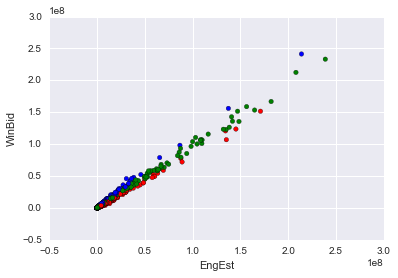

In [256]:
cmap = {'0': 'g', '1': 'r', '2': 'b' }
df['cMoreOrLessThan10'] = df.MoreOrLessThan10.apply(lambda x: cmap[str(x)])
print df.plot('EngEst', 'WinBid', kind='scatter', c=df.cMoreOrLessThan10)

Axes(0.125,0.125;0.775x0.775)


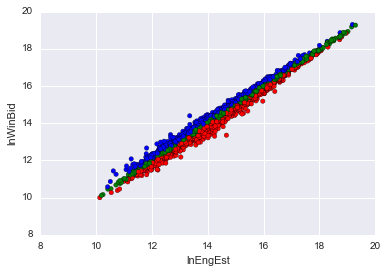

In [257]:
cmap = {'0': 'g', '1': 'r', '2': 'b' }
df['cMoreOrLessThan10'] = df.MoreOrLessThan10.apply(lambda x: cmap[str(x)])
print df.plot('lnEngEst', 'lnWinBid', kind='scatter', c=df.cMoreOrLessThan10)

# 1) Splitting the Data into Training and Testing Sets

In [258]:
df_test = df[(df.Year == 2016) & (df.Month == 4)]
print len(df_test) , 'projects in April 2016'

df_train = df[(df.Year != 2016) | (df.Month != 4)]
print len(df_train) ,'projects from Jan 2010 to April 2016'

#df_train[['Year','Month']].tail()

67 projects in April 2016
5110 projects from Jan 2010 to April 2016


In [242]:
#df_test.columns

   ### This will split the training and testing sets into a more useful format for loading into models

In [259]:
names_X = ['Length','NBidders','Year','Month','lnEngEst','Time']

def X_y(df):
    X = df[ names_X ]
    y_more = df['MoreThan10']
    y_less =df['LessThan10']
    return X, y_more, y_less

train_X, train_y_more, train_y_less = X_y(df_train)
test_X, test_y_more, test_y_less = X_y(df_test)

print len(train_y_more)
print len(train_y_less)
print len(test_y_more)
print len(test_y_less)

5110
5110
67
67


In [260]:
test_X.head()

,Length,NBidders,Year,Month,lnEngEst,Time
Date,,,,,,
2016-04-05,15.055,2,2016,4,14.979827,0.0
2016-04-06,0.016,5,2016,4,14.722602,0.0
2016-04-06,2.024,4,2016,4,16.836501,0.0
2016-04-06,6.294,3,2016,4,14.893941,0.0
2016-04-06,0.455,3,2016,4,13.837735,0.0


# Probabilistic Classifying using Logistic Regression

> ## More Than 10%

#### Training

In [261]:
model_1 = linear_model.LogisticRegression()
model_1.fit(train_X, train_y_more)

print 'intercept    =', model_1.intercept_
print 'coefficients =', model_1.coef_

intercept    = [ 0.0001453]
coefficients = [[ 0.00230722  0.21597156 -0.00191552  0.0116006   0.15382005 -0.00279872]]


#### Scoring

In [262]:
print 'correct training classification = ', model_1.score(train_X, train_y_more)
print 'correct testing classification = ', model_1.score(test_X, test_y_more)

correct training classification =  0.714677103718
correct testing classification =  0.65671641791


#### Predicting

In [263]:
y_logit_more = model_1.intercept_ + (test_X * model_1.coef_[0]).sum(axis = 1)
y_odds_more = np.exp(y_logit_more)
y_p_more = y_odds_more / (1 + y_odds_more)
y_p_more.head()

Date
2016-04-05    0.260327
2016-04-06    0.384470
2016-04-06    0.411735
2016-04-06    0.296980
2016-04-06    0.261602
dtype: float64

In [266]:
df_test.loc[:,'p_more'] = y_p_more

> ## Less Than 10%

#### Training

In [267]:
model_2 = linear_model.LogisticRegression()
model_2.fit(train_X, train_y_less)

print 'intercept    =', model_2.intercept_
print 'coefficients =', model_2.coef_

intercept    = [-0.00046124]
coefficients = [[-0.01289253 -0.40220173  0.00238074 -0.01342247 -0.32558187  0.00243721]]


#### Scoring

In [268]:
print 'correct training classification = ', model_2.score(train_X, train_y_less)
print 'correct testing  classification = ', model_2.score(test_X, test_y_less)

correct training classification =  0.791585127202
correct testing  classification =  0.731343283582


#### Predicting

In [269]:
y_logit_less = model_2.intercept_ + (test_X * model_2.coef_[0]).sum(axis = 1)
y_odds_less = np.exp(y_logit_less)
y_p_less = y_odds_less / (1 + y_odds_less)
y_p_less.head()

Date
2016-04-05    0.244116
2016-04-06    0.113125
2016-04-06    0.085400
2016-04-06    0.199164
2016-04-06    0.274409
dtype: float64

In [270]:
df_test.loc[:,'p_less'] = y_p_less

> ## Within 10%

#### P(within) = 1- P(more) - P(less)

In [271]:
y_p_within = 1-y_p_more - y_p_less

y_p_within.head()

Date
2016-04-05    0.495556
2016-04-06    0.502405
2016-04-06    0.502865
2016-04-06    0.503856
2016-04-06    0.463989
dtype: float64

In [272]:
df_test.loc[:,'p_within'] = y_p_within

# Model given Wining Bid is within 10% of TxDot Estimate

In [274]:
#subsets the training data to just those who were within 10% of the TxDot Estimate
df_train_within = df[df.Within10Percent == 1]

model_3 = smf.ols(formula = 'lnWinBid ~ lnEngEst+Year+Month+Year*Month+NBidders+NBidders*Year+Time', data = df_train_within).fit()
model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               lnWinBid   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 2.592e+05
Date:                Wed, 01 Jun 2016   Prob (F-statistic):               0.00
Time:                        17:52:08   Log-Likelihood:                 3907.2
No. Observations:                2606   AIC:                            -7798.
Df Residuals:                    2598   BIC:                            -7752.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept        -3.2112      3.597     -0.893      0.372       -10.265     3.843
lnEngEst          0.9956      0.001    956.110      0.000         0.994     0.998
Year              0.0016      0.002      0.909      0.363        -0.002     0.005
Month             0.2336      0.364      0.641      0.521        -0.481     0.948
Year:Month       -0.0001      0.000     -0.641      0.522        -0.000     0.000
NBidders         -0.2604      0.545     -0.478      0.633        -1.328     0.808
NBidders:Year     0.0001      0.000      0.471      0.638        -0.000     0.001
Time           4.125e-05   8.94e-06      4.613      0.000      2.37e-05  5.88e-05
==============================================================================
Omnibus:                      576.150   Durbin-Watson:                   1.925
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              121.613
Skew:                           0.183   Prob(JB):                     3.91e-27
Kurtosis:                       2.007   Cond. No.                     5.79e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.79e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Predicting

In [275]:
df_test.loc[:,'Lnprediction_within'] = model_3.predict(test_X)
df_test.Lnprediction_within.head()

Date
2016-04-05    14.972721
2016-04-06    14.706426
2016-04-06    16.814502
2016-04-06    14.883813
2016-04-06    13.832213
Name: Lnprediction_within, dtype: float64

# Model given Wining Bid is More Than 10% of TxDot Estimate

In [276]:
#subsets the training data to just those who were more than 10% of the TxDot Estimate
df_train_more = df[df.MoreThan10 == 1]

model_4 = smf.ols(formula = 'lnWinBid ~ lnEngEst+Year+Month+Year*Month+NBidders+NBidders*Year+Time', data = df_train_more).fit()
model_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               lnWinBid   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                 2.733e+04
Date:                Wed, 01 Jun 2016   Prob (F-statistic):               0.00
Time:                        17:52:22   Log-Likelihood:                 1033.0
No. Observations:                1488   AIC:                            -2050.
Df Residuals:                    1480   BIC:                            -2008.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept       -13.2256     10.209     -1.296      0.195       -33.250     6.799
lnEngEst          1.0004      0.003    332.010      0.000         0.995     1.006
Year              0.0065      0.005      1.273      0.203        -0.003     0.016
Month            -0.5925      0.938     -0.632      0.528        -2.432     1.247
Year:Month        0.0003      0.000      0.633      0.527        -0.001     0.001
NBidders          3.0432      1.479      2.057      0.040         0.141     5.945
NBidders:Year    -0.0015      0.001     -2.060      0.040        -0.003 -7.25e-05
Time            8.62e-05   2.87e-05      3.000      0.003      2.98e-05     0.000
==============================================================================
Omnibus:                      744.819   Durbin-Watson:                   1.877
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5533.375
Skew:                          -2.224   Prob(JB):                         0.00
Kurtosis:                      11.335   Cond. No.                     5.77e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.77e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Predicting

In [277]:
df_test.loc[:,'Lnprediction_more'] = model_4.predict(test_X)

# Model given Wining Bid is Less Than 10% of TxDot Estimate

In [278]:
#subsets the training data to just those who were less than 10% of the TxDot Estimate
df_train_less = df[df.LessThan10 == 1]

model_5 = smf.ols(formula = 'lnWinBid ~ lnEngEst+Year+Month+Year*Month+NBidders+NBidders*Year+Time', data = df_train_less).fit()
model_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               lnWinBid   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 2.895e+04
Date:                Wed, 01 Jun 2016   Prob (F-statistic):               0.00
Time:                        17:52:27   Log-Likelihood:                 1000.8
No. Observations:                1083   AIC:                            -1986.
Df Residuals:                    1075   BIC:                            -1946.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept       -33.7856     10.879     -3.106      0.002       -55.131   -12.440
lnEngEst          0.9719      0.003    310.603      0.000         0.966     0.978
Year              0.0171      0.005      3.161      0.002         0.006     0.028
Month             0.3353      1.180      0.284      0.776        -1.981     2.651
Year:Month       -0.0002      0.001     -0.283      0.777        -0.001     0.001
NBidders          6.5230      1.825      3.574      0.000         2.942    10.104
NBidders:Year    -0.0032      0.001     -3.581      0.000        -0.005    -0.001
Time              0.0001      3e-05      3.943      0.000      5.95e-05     0.000
==============================================================================
Omnibus:                      473.873   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3314.246
Skew:                           1.872   Prob(JB):                         0.00
Kurtosis:                      10.709   Cond. No.                     5.76e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.76e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Predicting

In [279]:
df_test.loc[:,'Lnprediction_less'] = model_5.predict(test_X)

# Our Model Prediction of Winning Bid will be a Weighted average of Bid predictions with weights being the probability of being classified as such class found from Logistic Regression

In [280]:
#df_test.columns

df_test['Hyp_More'] = 1
df_test['Hyp_Less'] = 1
df_test['Hyp_Within'] = 1

In [283]:
df_test[['p_more', 'p_less', 'p_within', 'Lnprediction_within', 'Lnprediction_more', 'Lnprediction_less']].head()

,p_more,p_less,p_within,Lnprediction_within,Lnprediction_more,Lnprediction_less
Date,,,,,,
2016-04-05,0.260327,0.244116,0.495556,14.972721,14.779110,15.183437
2016-04-06,0.384470,0.113125,0.502405,14.706426,14.487806,14.866475
2016-04-06,0.411735,0.085400,0.502865,16.814502,16.613899,16.943218
2016-04-06,0.296980,0.199164,0.503856,14.883813,14.681865,15.077643
2016-04-06,0.261602,0.274409,0.463989,13.832213,13.625224,14.051156


## E[Bid] = P(within10)xE[within10] + P(above10)xE[above10] + P(below10)xE[below10]

In [284]:
df_test.loc[:,'lnpred'] = df_test.p_within*df_test.Lnprediction_within + df_test.p_more*df_test.Lnprediction_more + df_test.p_less*df_test.Lnprediction_less  

In [285]:
df_test.loc[:,'BidPrediction'] = np.exp(df_test.loc[:,'lnpred'])

In [286]:
df_test.loc[:,'PredDiff'] = df_test.loc[:,'BidPrediction'] - df_test.loc[:,'WinBid']
df_test.loc[:,'PredPercentOff'] = df_test.loc[:,'PredDiff'] / df_test.loc[:,'BidPrediction']

df_test.loc[:,'PredWithin10Percent'] = 1
df_test.loc[(df_test.PredPercentOff > .10) , 'PredWithin10Percent'] = 0
df_test.loc[(df_test.PredPercentOff < -.10) , 'PredWithin10Percent'] = 0

In [287]:
ModelPercent = float(df_test.PredWithin10Percent.sum()) / len(df_test)
PercentIncrease = (ModelPercent)*100 - (Percent_April_2016)*100
NumberCorrectIncrease = (PercentIncrease/100)*len(df_test)
print  (Percent_April_2016)*100 , '% of the TxDOT estimates were within 10% of actual bid'
print  (ModelPercent)*100 , '% of the Model predictions were within 10% of actual bid'
print 
print 'this is a increase of :', PercentIncrease, '%'
print 'or', NumberCorrectIncrease, 'more estimates within the 10% threshhold'

46.2686567164 % of the TxDOT estimates were within 10% of actual bid
53.7313432836 % of the Model predictions were within 10% of actual bid

this is a increase of : 7.46268656716 %
or 5.0 more estimates within the 10% threshhold


In [288]:
print 'In April 2016 TxDOT under estimated bids by: ' , df_test.Diff.sum()
print
print 'In April 2016 the Model under estimated bids by: ' ,df_test.PredDiff.sum()
print
print 'In April 2016 the model was ' , df_test.Diff.sum() - df_test.PredDiff.sum() , 'closer to the winning bids than TxDOT' 
print
print 'The model predicted a sum of' ,df_test.BidPrediction.sum() ,'for all the projects in April 2016'
print
print 'TxDOT predicted a sum of' ,df_test.EngEst.sum() ,'for all the projects in April 2016'

In April 2016 TxDOT under estimated bids by:  -3410280.24

In April 2016 the Model under estimated bids by:  -19260901.731

In April 2016 the model was  15850621.491 closer to the winning bids than TxDOT

The model predicted a sum of 209008961.949 for all the projects in April 2016

TxDOT predicted a sum of 224859583.44 for all the projects in April 2016


In [289]:
df_test[['Diff','PredDiff']].std()

Diff        659308.564868
PredDiff    857344.883547
dtype: float64

In [290]:
df_test[['Diff','PredDiff']].describe()

,Diff,PredDiff
count,6.700000e+01,6.700000e+01
mean,-5.089971e+04,-2.874761e+05
std,6.593086e+05,8.573449e+05
min,-3.178934e+06,-5.011753e+06
25%,-1.510351e+05,-3.104509e+05
50%,1.591124e+04,-7.131061e+04
75%,1.269111e+05,4.398933e+04
max,1.390280e+06,9.164722e+05


# Bid Model Comparison by Graph

> Red is Bad  (beyond the 10% threshhold)

> Green is Good   (within 10% of actual)

## TxDOT Estimates

Axes(0.125,0.125;0.775x0.775)


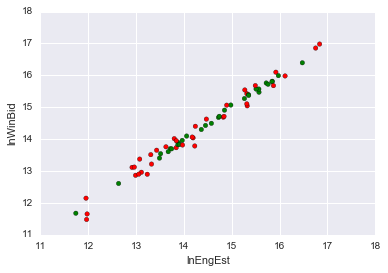

In [291]:
cmap = {'0': 'r', '1': 'g' }
df_test.loc[:,'cWithin10Percent'] = df_test.Within10Percent.apply(lambda x: cmap[str(x)])
print df_test.plot('lnEngEst', 'lnWinBid', kind='scatter', c=df_test.cWithin10Percent)

## Model Predictions

Axes(0.125,0.125;0.775x0.775)


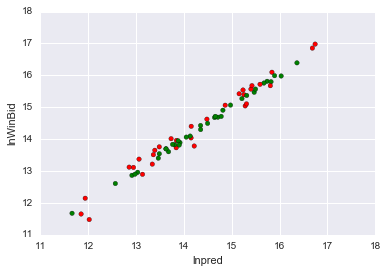

In [292]:
predcmap = {'0': 'r', '1': 'g' }
df_test.loc[:,'cPredWithin10Percent'] = df_test.PredWithin10Percent.apply(lambda x: predcmap[str(x)])
print df_test.plot('lnpred', 'lnWinBid', kind='scatter', c=df_test.cPredWithin10Percent)